### Data Loading

Load in Data from .mat files

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

from processing_utils.feature_data_from_mat import load_subject_high_gamma

In [2]:
hg_trace, hg_map, phon_labels = load_subject_high_gamma('S14', sig_channel=False, zscore=False)

(149, 200, 128)
(149, 8, 16, 200)
(149, 3)


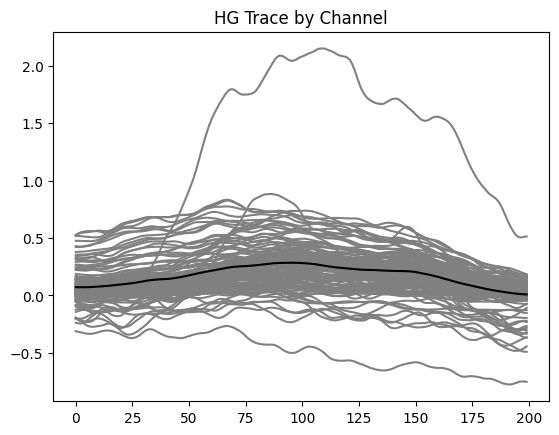

In [3]:
print(hg_trace.shape)
print(hg_map.shape)
print(phon_labels.shape)

plt.figure()
plt.plot(np.mean(hg_trace, axis=0), 'grey')
plt.plot(np.mean(np.mean(hg_trace, axis=0), axis=1), 'black')
plt.title('HG Trace by Channel')
plt.show()

Process data for use with 1/3 D CNN Bidirectional LSTM seq2seq

In [4]:
# imports
from processing_utils.sequence_processing import pad_sequence_teacher_forcing

In [5]:
# parameters
n_output = 10

In [6]:
X = hg_trace  # use HG traces (n_trials, n_channels, n_timepoints) for 1D CNN
# X = hg_map  # use HG channel map stack (n_trials, n_channels_x, n_channels_y, n_timepoints) for 1D CNN
X_prior, y, prior_labels, seq_labels = pad_sequence_teacher_forcing(phon_labels, n_output)  # first 2 outputs one-hot encoded

In [7]:
print(X.shape, X_prior.shape, y.shape, prior_labels.shape, seq_labels.shape)

(149, 200, 128) (149, 3, 10) (149, 3, 10) (149, 3) (149, 3)


Build 1D CNN Bidirectional LSTM seq2seq Model

In [8]:
# imports
from seq2seq_models.rnn_models import (lstm_1Dcnn_model, gru_1Dcnn_model, 
                                       lstm_3Dcnn_model, gru_3Dcnn_model,
                                       stacked_lstm_1Dcnn_model)


In [11]:
# parameters

# 1D CNN
n_input_time = X.shape[1]
n_input_channel = X.shape[2]
filter_size = 10

# 3D CNN
# n_input_channel = [X.shape[1], X.shape[2]]
# n_input_time = X.shape[3]
# filter_size = 2

n_filters = 50
n_units = 200
n_layers = 3
reg_lambda = 1e-6
dropout = 0.0
bidir = True

In [12]:
# train_model, inf_enc, inf_dec = lstm_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir, dropout=dropout)
# train_model, inf_enc, inf_dec = lstm_3Dcnn_model(n_input_time, n_input_x, n_input_y, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)
# train_model, inf_enc, inf_dec = gru_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)
# train_model, inf_enc, inf_dec = gru_3Dcnn_model(n_input_time, n_input_x, n_input_y, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)
train_model, inf_enc, inf_dec = stacked_lstm_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_layers, n_units, reg_lambda, bidir=bidir, dropout=dropout)

Creating layer 0 ...
Creating layer 1 ...


In [11]:
print(train_model.summary())
print(train_model.layers[-1].summary())
print(inf_enc.summary())
print(inf_enc.layers[-1].summary())
print(inf_dec.summary())

Model: "training_lstm_final"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 128)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 20, 50)       64050       ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None, 10)]   0           []                               
                                                                                                  
 training_lstm_initial (Functio  (None, None, 10)    572410      ['conv1d[0][0]',                 
 nal)                                                             'input_2[0][0]

In [12]:
new_model, new_enc, new_dec = lstm_1Dcnn_model(n_input_time, 256, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir, dropout=dropout)
for layer in new_model.layers:
        try:
            layer.set_weights(train_model.get_layer(name=layer.name).get_weights())
        except:
            print("Could not transfer weights for layer {}".format(layer.name))

Could not transfer weights for layer input_7
Could not transfer weights for layer conv1d_1
Could not transfer weights for layer input_8


In [13]:
new_lstm_w = new_model.layers[-1].layers[1].get_weights()[0]
old_lstm_w = train_model.layers[-1].layers[1].get_weights()[0]
print(np.array_equal(new_lstm_w, old_lstm_w))
print(new_lstm_w)
print(old_lstm_w)

True
[[-0.00368688  0.01651912 -0.02418898 ...  0.00959753  0.01160295
   0.0250731 ]
 [ 0.02608936  0.04649424  0.02155476 ...  0.03072763 -0.0383791
  -0.07317666]
 [ 0.06040842 -0.04159138 -0.0711669  ... -0.00671875 -0.07634833
   0.00688287]
 ...
 [-0.07953047  0.05667485  0.07165314 ... -0.0775983   0.00469559
   0.01744318]
 [-0.08239654  0.05907101  0.00893252 ...  0.0145665   0.03834851
  -0.0202676 ]
 [-0.02137321  0.03549391  0.08189128 ... -0.02511157 -0.03956464
   0.04923034]]
[[-0.00368688  0.01651912 -0.02418898 ...  0.00959753  0.01160295
   0.0250731 ]
 [ 0.02608936  0.04649424  0.02155476 ...  0.03072763 -0.0383791
  -0.07317666]
 [ 0.06040842 -0.04159138 -0.0711669  ... -0.00671875 -0.07634833
   0.00688287]
 ...
 [-0.07953047  0.05667485  0.07165314 ... -0.0775983   0.00469559
   0.01744318]
 [-0.08239654  0.05907101  0.00893252 ...  0.0145665   0.03834851
  -0.0202676 ]
 [-0.02137321  0.03549391  0.08189128 ... -0.02511157 -0.03956464
   0.04923034]]


### Hyperparameter Optimization

In [27]:
import keras_tuner as kt
from sklearn.model_selection import ShuffleSplit
from train.optimize import encDecHyperModel, encDecTuner

In [28]:
data_split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=2)
train_idx, test_idx = next(data_split.split(X))
X_train, X_test = X[train_idx], X[test_idx]
X_prior_train, X_prior_test = X_prior[train_idx], X_prior[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [29]:
optim_trials = 100
hyper_model = encDecHyperModel(lstm_1Dcnn_model, n_input_time, n_input_channel, n_output)
rnn_optimizer = encDecTuner(hypermodel=hyper_model,
                            oracle=kt.oracles.RandomSearchOracle(objective=kt.Objective('val_accuracy', direction='max'),
                                                                 max_trials=optim_trials),
                            directory='data/rnn_tuning', project_name='S14_1Dcnn_LSTM')

INFO:tensorflow:Reloading Tuner from data/rnn_tuning\S14_1Dcnn_LSTM\tuner0.json


In [30]:
rnn_optimizer.search(X_train, X_prior_train, y_train, epochs=800)

Trial 7 Complete [00h 00m 01s]

Best val_accuracy So Far: 0.11518564265089311
Total elapsed time: 00h 00m 04s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
190               |170               |num_filts
400               |300               |rnn_units
0.0001            |1e-05             |reg_lambda



Traceback (most recent call last):
  File "f:\RNN_transfer_learning\RNN_phoneme_decoding_micro\.venv\lib\site-packages\keras_tuner\engine\base_tuner.py", line 266, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "f:\RNN_transfer_learning\RNN_phoneme_decoding_micro\.venv\lib\site-packages\keras_tuner\engine\base_tuner.py", line 231, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "f:\RNN_transfer_learning\RNN_phoneme_decoding_micro\phoneme_encoder_decoder\train\optimize.py", line 57, in run_trial
    _, y_pred, y_test = self.hypermodel.fit(model, inf_enc, inf_dec,
  File "f:\RNN_transfer_learning\RNN_phoneme_decoding_micro\phoneme_encoder_decoder\train\optimize.py", line 45, in fit
    return train_seq2seq_kfold(model, *args, verbose=0, **kwargs)
  File "f:\RNN_transfer_learning\RNN_phoneme_decoding_micro\phoneme_encoder_decoder\train\train.py", line 117, in train_seq2seq_kfold
    fold = int

RuntimeError: Number of consecutive failures excceeded the limit of 3.
Traceback (most recent call last):
  File "f:\RNN_transfer_learning\RNN_phoneme_decoding_micro\.venv\lib\site-packages\keras_tuner\engine\base_tuner.py", line 266, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "f:\RNN_transfer_learning\RNN_phoneme_decoding_micro\.venv\lib\site-packages\keras_tuner\engine\base_tuner.py", line 231, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "f:\RNN_transfer_learning\RNN_phoneme_decoding_micro\phoneme_encoder_decoder\train\optimize.py", line 57, in run_trial
    _, y_pred, y_test = self.hypermodel.fit(model, inf_enc, inf_dec,
  File "f:\RNN_transfer_learning\RNN_phoneme_decoding_micro\phoneme_encoder_decoder\train\optimize.py", line 45, in fit
    return train_seq2seq_kfold(model, *args, verbose=0, **kwargs)
  File "f:\RNN_transfer_learning\RNN_phoneme_decoding_micro\phoneme_encoder_decoder\train\train.py", line 117, in train_seq2seq_kfold
    fold = int((len(histories["accuracy"]) / num_reps) + 1)
KeyError: 'accuracy'


In [ ]:
rnn_optimizer.results_summary()

In [ ]:
optim_params = rnn_optimizer.get_best_hyperparameters(num_trials=10)[0].values
print(optim_params)

In [ ]:
from keras.optimizers import Adam
optim_model, optim_enc, optim_dec = lstm_1Dcnn_model(n_input_time, n_input_channel,
                                                     n_output, n_filters=optim_params['num_filts'],
                                                     filter_size=10, n_units=optim_params['rnn_units'],
                                                     reg_lambda=optim_params['reg_lambda'])

learning_rate = 5e-4
optim_model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from train.train import train_seq2seq, decode_seq2seq

_, histories = train_seq2seq(optim_model, X_train, X_prior_train, y_train, epochs=800)


In [ ]:
from sklearn.metrics import balanced_accuracy_score

y_pred_optim, y_test_optim = decode_seq2seq(optim_enc, optim_dec, X_test, y_test)
print(f'Hyperparameter Optimized Balanced Accuracy: {balanced_accuracy_score(y_test_optim, y_pred_optim)}')

### Train Model

In [14]:
# imports
import time
import tensorflow as tf
from keras.optimizers import Adam
from train.train import train_seq2seq_kfold, train_seq2seq

In [15]:
tf.config.list_physical_devices('GPU')

[]

In [16]:
# parameters
num_folds = 10
num_reps = 1
batch_size = 200
epochs = 5
learning_rate = 1e-3

train_model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
from train.seq2seq_predict_callback import seq2seq_predict_callback
from sklearn.model_selection import ShuffleSplit

data_split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=2)
train_idx, test_idx = next(data_split.split(X))
X_train, X_test = X[train_idx], X[test_idx]
X_prior_train, X_prior_test = X_prior[train_idx], X_prior[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

s2s_cb = seq2seq_predict_callback(train_model, inf_enc, inf_dec, X_test, y_test)

In [18]:
_, history = train_seq2seq(train_model, X, X_prior, y, epochs=epochs, batch_size=batch_size, validation_data=([X_test, X_prior_test], y_test), callbacks=[s2s_cb])

Epoch 1/5
1/1 [==============================] - 15s 15s/step - loss: 2.3026 - accuracy: 0.1253 - val_loss: 2.2221 - val_accuracy: 0.1667 - seq2seq_val_loss: 2.2265 - seq2seq_val_accuracy: 0.1140
Epoch 2/5
1/1 [==============================] - 7s 7s/step - loss: 2.2364 - accuracy: 0.1723 - val_loss: 2.1598 - val_accuracy: 0.2000 - seq2seq_val_loss: 2.1653 - seq2seq_val_accuracy: 0.1458
Epoch 3/5
1/1 [==============================] - 7s 7s/step - loss: 2.1809 - accuracy: 0.1991 - val_loss: 2.1075 - val_accuracy: 0.2556 - seq2seq_val_loss: 2.1142 - seq2seq_val_accuracy: 0.1757
Epoch 4/5
1/1 [==============================] - 8s 8s/step - loss: 2.1285 - accuracy: 0.2438 - val_loss: 2.0728 - val_accuracy: 0.2667 - seq2seq_val_loss: 2.0809 - seq2seq_val_accuracy: 0.1989
Epoch 5/5
1/1 [==============================] - 8s 8s/step - loss: 2.0797 - accuracy: 0.2528 - val_loss: 2.0382 - val_accuracy: 0.3333 - seq2seq_val_loss: 2.0477 - seq2seq_val_accuracy: 0.2528


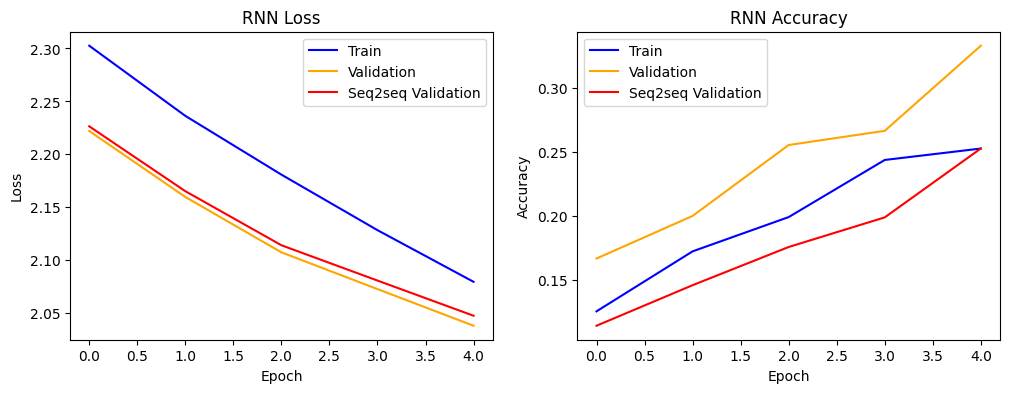

In [19]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['loss'], color='blue', label='Train')
ax1.plot(history.history['val_loss'], color='orange', label='Validation')
ax1.plot(history.history['seq2seq_val_loss'], color='red', label='Seq2seq Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('RNN Loss')
ax1.legend()

ax2.plot(history.history['accuracy'], color='blue', label='Train')
ax2.plot(history.history['val_accuracy'], color='orange', label='Validation')
ax2.plot(history.history['seq2seq_val_accuracy'], color='red', label='Seq2seq Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('RNN Accuracy')
ax2.legend()


plt.show()

In [17]:
start = time.time()
histories, y_pred_all, y_test_all = train_seq2seq_kfold(train_model, inf_enc, inf_dec, X, X_prior, y,
                                                        num_folds=num_folds, num_reps=num_reps,
                                                        batch_size=batch_size, 
                                                        epochs=epochs, early_stop=False)
end = time.time()


===== Fold 1 =====
Epoch 1/5
1/1 [==============================] - 11s 11s/step - loss: 2.3013 - accuracy: 0.0970 - val_loss: 2.2438 - val_accuracy: 0.1333 - seq2seq_val_loss: 2.2432 - seq2seq_val_accuracy: 0.0921
Epoch 2/5
1/1 [==============================] - 4s 4s/step - loss: 2.2338 - accuracy: 0.1493 - val_loss: 2.1904 - val_accuracy: 0.1778 - seq2seq_val_loss: 2.1915 - seq2seq_val_accuracy: 0.1270
Epoch 3/5
1/1 [==============================] - 5s 5s/step - loss: 2.1929 - accuracy: 0.1891 - val_loss: 2.1610 - val_accuracy: 0.1778 - seq2seq_val_loss: 2.1638 - seq2seq_val_accuracy: 0.1111
Epoch 4/5
1/1 [==============================] - 5s 5s/step - loss: 2.1645 - accuracy: 0.1841 - val_loss: 2.1464 - val_accuracy: 0.2000 - seq2seq_val_loss: 2.1508 - seq2seq_val_accuracy: 0.1501
Epoch 5/5
1/1 [==============================] - 4s 4s/step - loss: 2.1361 - accuracy: 0.2239 - val_loss: 2.1387 - val_accuracy: 0.2889 - seq2seq_val_loss: 2.1447 - seq2seq_val_accuracy: 0.2024
===== Fol

f:\RNN_transfer_learning\RNN_phoneme_decoding_micro\.venv\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


1/1 [==============================] - 4s 4s/step - loss: 2.3679 - accuracy: 0.0846 - val_loss: 2.3317 - val_accuracy: 0.0222 - seq2seq_val_loss: 2.3330 - seq2seq_val_accuracy: 0.0222
Epoch 3/5
1/1 [==============================] - 5s 5s/step - loss: 2.3239 - accuracy: 0.1318 - val_loss: 2.2994 - val_accuracy: 0.1333 - seq2seq_val_loss: 2.3009 - seq2seq_val_accuracy: 0.1333
Epoch 4/5
1/1 [==============================] - 5s 5s/step - loss: 2.2812 - accuracy: 0.1269 - val_loss: 2.2744 - val_accuracy: 0.0889 - seq2seq_val_loss: 2.2763 - seq2seq_val_accuracy: 0.1111
Epoch 5/5
1/1 [==============================] - 4s 4s/step - loss: 2.2454 - accuracy: 0.1443 - val_loss: 2.2569 - val_accuracy: 0.0889 - seq2seq_val_loss: 2.2592 - seq2seq_val_accuracy: 0.1111
===== Fold 5 =====
Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 2.3573 - accuracy: 0.1468 - val_loss: 2.3149 - val_accuracy: 0.0667 - seq2seq_val_loss: 2.3101 - seq2seq_val_accuracy: 0.1270
Epoch 2/5
1/1 [======

f:\RNN_transfer_learning\RNN_phoneme_decoding_micro\.venv\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


1/1 [==============================] - 4s 4s/step - loss: 2.3204 - accuracy: 0.0970 - val_loss: 2.2841 - val_accuracy: 0.2444 - seq2seq_val_loss: 2.2860 - seq2seq_val_accuracy: 0.1440
Epoch 3/5
1/1 [==============================] - 4s 4s/step - loss: 2.2872 - accuracy: 0.1542 - val_loss: 2.2571 - val_accuracy: 0.2000 - seq2seq_val_loss: 2.2594 - seq2seq_val_accuracy: 0.1599
Epoch 4/5
1/1 [==============================] - 4s 4s/step - loss: 2.2525 - accuracy: 0.1642 - val_loss: 2.2345 - val_accuracy: 0.1556 - seq2seq_val_loss: 2.2375 - seq2seq_val_accuracy: 0.1071
Epoch 5/5
1/1 [==============================] - 4s 4s/step - loss: 2.2203 - accuracy: 0.1940 - val_loss: 2.2186 - val_accuracy: 0.0889 - seq2seq_val_loss: 2.2221 - seq2seq_val_accuracy: 0.1111
===== Fold 7 =====
Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 2.3378 - accuracy: 0.1144 - val_loss: 2.3685 - val_accuracy: 0.0667 - seq2seq_val_loss: 2.3684 - seq2seq_val_accuracy: 0.1111
Epoch 2/5
1/1 [======

In [44]:
print(f'Time to train {num_folds} folds: {end-start} seconds')

Time to train 10 folds: 464.54320549964905 seconds


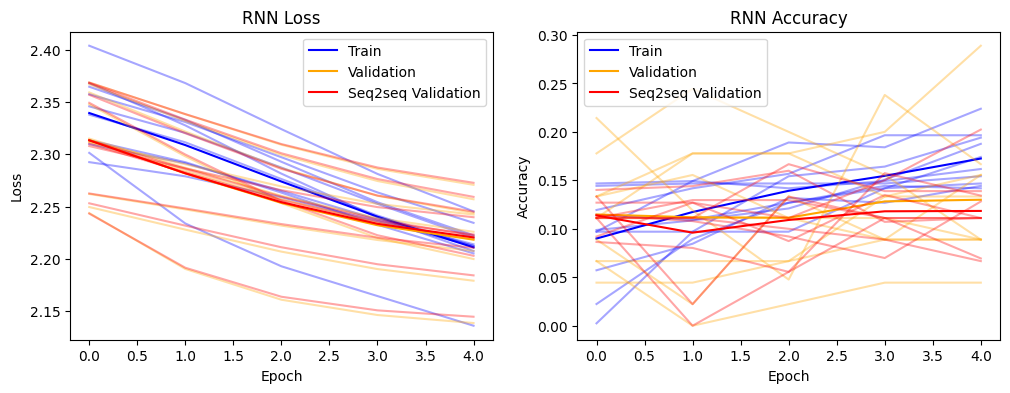

In [18]:
from visualization.plot_model_performance import extend_history_lists

histories = extend_history_lists(histories, epochs=epochs)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(np.array(histories['loss']).T, color='blue', alpha=0.35)
ax1.plot(np.mean(histories['loss'], axis=0), color='blue', label='Train')
ax1.plot(np.array(histories['val_loss']).T, color='orange', alpha=0.35)
ax1.plot(np.mean(histories['val_loss'], axis=0), color='orange', label='Validation')
ax1.plot(np.array(histories['seq2seq_val_loss']).T, color='red', alpha=0.35)
ax1.plot(np.mean(histories['seq2seq_val_loss'], axis=0), color='red', label='Seq2seq Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('RNN Loss')
ax1.legend()

ax2.plot(np.array(histories['accuracy']).T, color='blue', alpha=0.35)
ax2.plot(np.mean(histories['accuracy'], axis=0), color='blue', label='Train')
ax2.plot(np.array(histories['val_accuracy']).T, color='orange', alpha=0.35)
ax2.plot(np.mean(histories['val_accuracy'], axis=0), color='orange', label='Validation')
ax2.plot(np.array(histories['seq2seq_val_accuracy']).T, color='red', alpha=0.35)
ax2.plot(np.mean(histories['seq2seq_val_accuracy'], axis=0), color='red', label='Seq2seq Validation')
# ax2.axhline(1/(n_output-1), color='gray', linestyle='--', label='Chance')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('RNN Accuracy')
ax2.legend()

plt.show()

In [19]:
from sklearn.metrics import balanced_accuracy_score

print(f'Balanced Accuracy: {balanced_accuracy_score(y_test_all, y_pred_all)}')

Balanced Accuracy: 0.10234266331019166


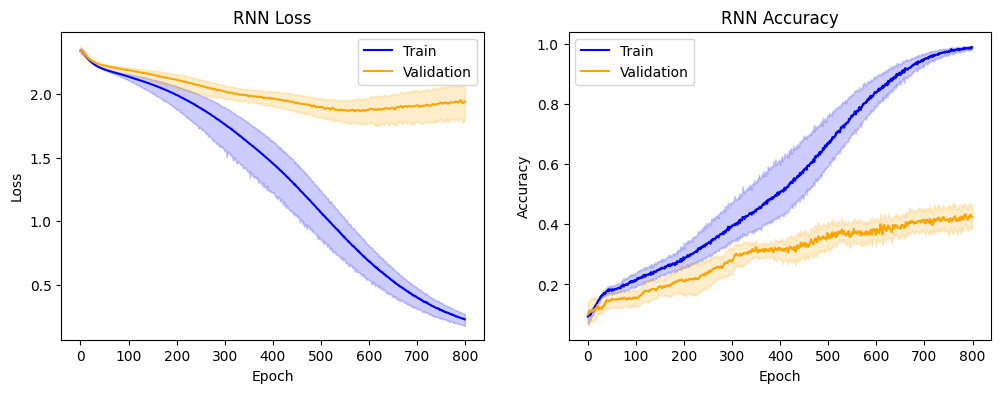

In [47]:
from visualization.plot_model_performance import plot_accuracy_loss

plot_accuracy_loss(histories, epochs=epochs)